In [12]:
from MAUtil import *
from MAInit import *
from MACalc import *
from MAPost import *
import re
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [13]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

In [14]:
db = client.adsE_database
collection = db.adsE_collection

### prepare data for prediction ###

In [15]:
elements = ['Ag', 'Al', 'Au', 'Cu', 'Pt', 'Pd', 'Ni', 'Rh']
faces = ['100', '111', '110', '211']

dictlis = []

for ele in elements:
    for face in faces:
        dicte = {'element':ele, 'face':face}
        dictlis.append(dicte)

dictlis.append({'element':'Ru', 'face':'001'})
dictlis.append({'element':'Zn', 'face':'001'})

dictlis.append({'element':'CoPt3', 'face':'100'})
dictlis.append({'element':'GaNi', 'face':'110'})

In [16]:
inst = []
dfall = []
df = []
dfpred = []

for i in range(len(dictlis)):
    try:
        du = dataset_utilizer('adsE_method3', **dictlis[i])
        inst.append(du)
        dfall.append(du.dfall)
        df.append(du.df)
        dfpred.append(du.dfpred)
    except:
        print('Error: {0}'.format(dictlis[i]))

In [6]:
### Exclude coverage > 1.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['coverage'] <= 1.0]

### Exclude ads ene > 2.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['aveadsE/suratom'] >= -2.0]

In [7]:
covset = []
for i in range(len(dfpred)):
    covset.append(sorted(list(set(dfpred[i]['coverage']))))
# covset

### Just show residue ####

In [94]:
dfpred[0]

,index,_id,name,isvalid,ispredictable,element,face,unitlength,xc,adsorbate,numberofads,coverage,surfatomnum,E,bareE,E_ads,totaladsE,aveadsE/suratom,aveadsE/ads,E_int_space,sumE_each_ads,E_residue/suratom,area,density,igroups,rgroups,converged,is_adsorbed,kept_sites,E_not_exceeded,minimum_distance,ads_dist2,ads_dist3
0,2,5e7e8697188fc29debd7caec,Ag_100_u2_RPBE_no002_CO_n2_d3.traj,yes,yes,Ag,100,2,RPBE,CO,2,0.50,4,-61.373971,-32.474988,-14.485436,0.071890,0.017972,0.035945,0.239696,-0.120858,-0.011737,35.502184,0.056335,"[0, 0]","[0, 0]",yes,yes,yes,yes,3,0.0,0.5000
1,4,5e7e86a4188fc29debd7caf0,Ag_100_u2_RPBE_no003_CO_n3_d3.traj,yes,yes,Ag,100,2,RPBE,CO,3,0.75,4,-75.670604,-32.474988,-14.485436,0.260692,0.065173,0.086897,0.494535,-0.181286,-0.013139,35.502184,0.084502,"[0, 0, 0]","[0, 0, 0]",yes,yes,yes,yes,3,0.0,1.0000
2,5,5e7e86b1188fc29debd7caf2,Ag_100_u2_RPBE_no004_CO_n4_d3.traj,yes,yes,Ag,100,2,RPBE,CO,4,1.00,4,-89.715536,-32.474988,-14.485436,0.701197,0.175299,0.175299,1.027711,-0.241715,-0.021199,35.502184,0.112669,"[0, 0, 0, 0]","[0, 0, 0, 0]",yes,yes,yes,yes,3,0.0,2.0000
3,6,5e7e86bf188fc29debd7caf4,Ag_100_u2_RPBE_no005_CO_n3_d3.traj,yes,yes,Ag,100,2,RPBE,CO,3,0.75,4,-75.581672,-32.474988,-14.485436,0.349625,0.087406,0.116542,0.404338,-0.056917,0.000551,35.502184,0.084502,"[1, 0, 0]","[1, 0, 0]",yes,yes,yes,yes,3,0.0,1.0625
4,7,5e7e86cc188fc29debd7caf6,Ag_100_u2_RPBE_no006_CO_n4_d3.traj,yes,yes,Ag,100,2,RPBE,CO,4,1.00,4,-89.429922,-32.474988,-14.485436,0.986811,0.246703,0.246703,0.849630,0.007023,0.032540,35.502184,0.112669,"[1, 1, 0, 0]","[1, 1, 0, 0]",yes,yes,yes,yes,2,1.0,1.6250
5,8,5e7e86d9188fc29debd7caf8,Ag_100_u2_RPBE_no007_CO_n2_d3.traj,yes,yes,Ag,100,2,RPBE,CO,2,0.50,4,-61.552238,-32.474988,-14.485436,-0.106378,-0.026594,-0.053189,-0.017165,-0.120858,0.007911,35.502184,0.056335,"[0, 0]","[0, 0]",yes,yes,yes,yes,Over 4,0.0,0.0000
6,10,5e7e86f3188fc29debd7cafc,Ag_100_u2_RPBE_no009_CO_n3_d3.traj,yes,yes,Ag,100,2,RPBE,CO,3,0.75,4,-75.299307,-32.474988,-14.485436,0.631989,0.157997,0.210663,0.404339,0.067452,0.040050,35.502184,0.084502,"[1, 1, 0]","[1, 1, 0]",yes,yes,yes,yes,2,1.0,0.6250
7,11,5e7e8700188fc29debd7cafe,Ag_100_u2_RPBE_no011_CO_n2_d3.traj,yes,yes,Ag,100,2,RPBE,CO,2,0.50,4,-61.164965,-32.474988,-14.485436,0.280896,0.070224,0.140448,0.239695,0.127880,-0.021670,35.502184,0.056335,"[1, 1]","[1, 1]",yes,yes,yes,yes,3,0.0,0.3750
8,12,5e7e870c188fc29debd7cb00,Ag_100_u2_RPBE_no012_CO_n3_d3.traj,yes,yes,Ag,100,2,RPBE,CO,3,0.75,4,-75.162987,-32.474988,-14.485436,0.768310,0.192077,0.256103,0.494541,0.191821,0.020487,35.502184,0.084502,"[1, 1, 1]","[1, 1, 1]",yes,yes,yes,yes,2,1.0,0.6875
9,13,5e7e871a188fc29debd7cb02,Ag_100_u2_RPBE_no013_CO_n4_d3.traj,yes,yes,Ag,100,2,RPBE,CO,4,1.00,4,-89.098179,-32.474988,-14.485436,1.318554,0.329639,0.329639,1.027708,0.255761,0.008771,35.502184,0.112669,"[1, 1, 1, 1]","[1, 1, 1, 1]",yes,yes,yes,yes,2,2.0,1.2500


Ag 100 0.0005342570298262968
Ag 111 0.011850904695467183
Ag 110 0.0017850343711218802
Ag 211 0.0007326723823899933
Al 100 0.0014839438099084684
Al 111 0.005244707578313854
Al 110 0.0004726681792073698
Al 211 0.007804176047608113
Au 100 0.0037093252912995946
Au 111 0.05542613418480541
Au 110 0.0019495413268498885
Au 211 5.133593530810273e-05
Cu 100 0.006861210661829148
Cu 111 0.010012355734378198
Cu 110 0.0075831651359413955
Cu 211 9.618084493350897e-05
Pt 100 0.032045708411087136
Pt 111 0.04920174986573488
Pt 110 0.061758228783154734
Pt 211 0.0029665607399163717
Pd 100 0.03909728288145137
Pd 111 0.03706626383249074
Pd 110 0.041641567282464376
Pd 211 0.0016137967875358558
Ni 100 0.011266270322570857
Ni 111 0.012401751111926268
Ni 110 0.004929312352677112
Ni 211 0.0008168369052551665
Rh 100 0.006378257188467971
Rh 111 0.007950089271624888
Rh 110 0.009724748115559385
Rh 211 0.006200056631138052
CoPt3 100 0.0017706525905653208
GaNi 110 0.0015243283351909812


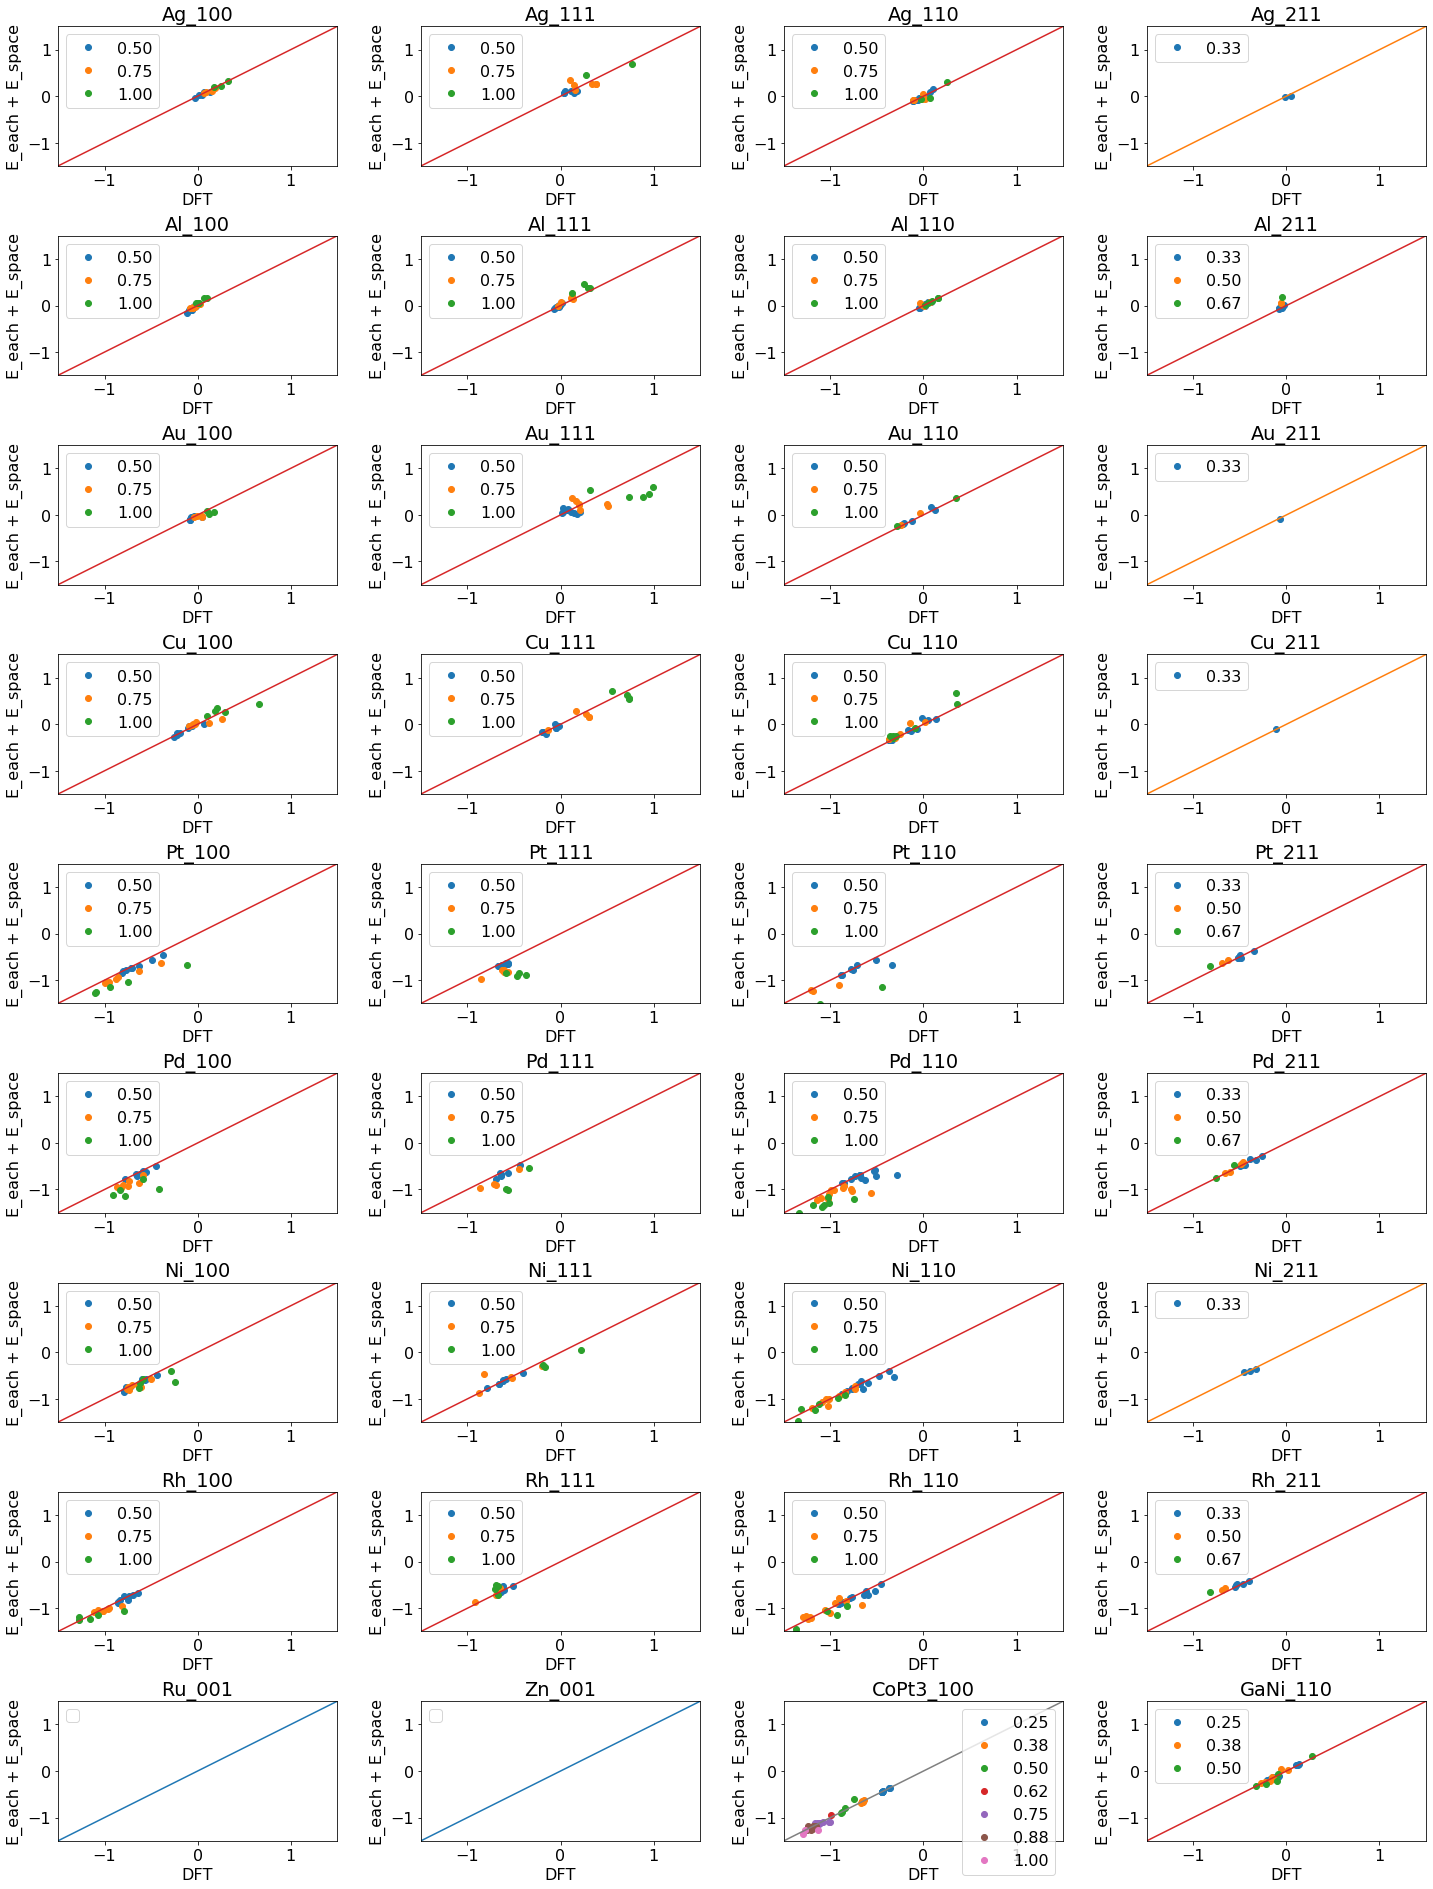

In [87]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(20,30))
plt.rcParams["font.size"] = 16

for i in range(len(dfpred)):
    ax = fig.add_subplot(9, 4, i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        if not covset[i][j]:
            continue
        data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        aveadsE_suratom = np.array(data['aveadsE/suratom'])
        E_residue = np.array(data['E_residue/suratom'])
        E_prepred = aveadsE_suratom - E_residue
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_prepred, 'o')
   
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    
    if not covset[i]:
        continue
    data = dfpred[i]
    aveadsE_suratom = np.array(data['aveadsE/suratom'])
    E_residue = np.array(data['E_residue/suratom'])
    E_prepred = aveadsE_suratom - E_residue    
    print(dictlis[i]['element'], dictlis[i]['face'], mean_squared_error(aveadsE_suratom, E_prepred))
    
# plt.savefig('E_residue.png', bbox_inches='tight')
plt.show()

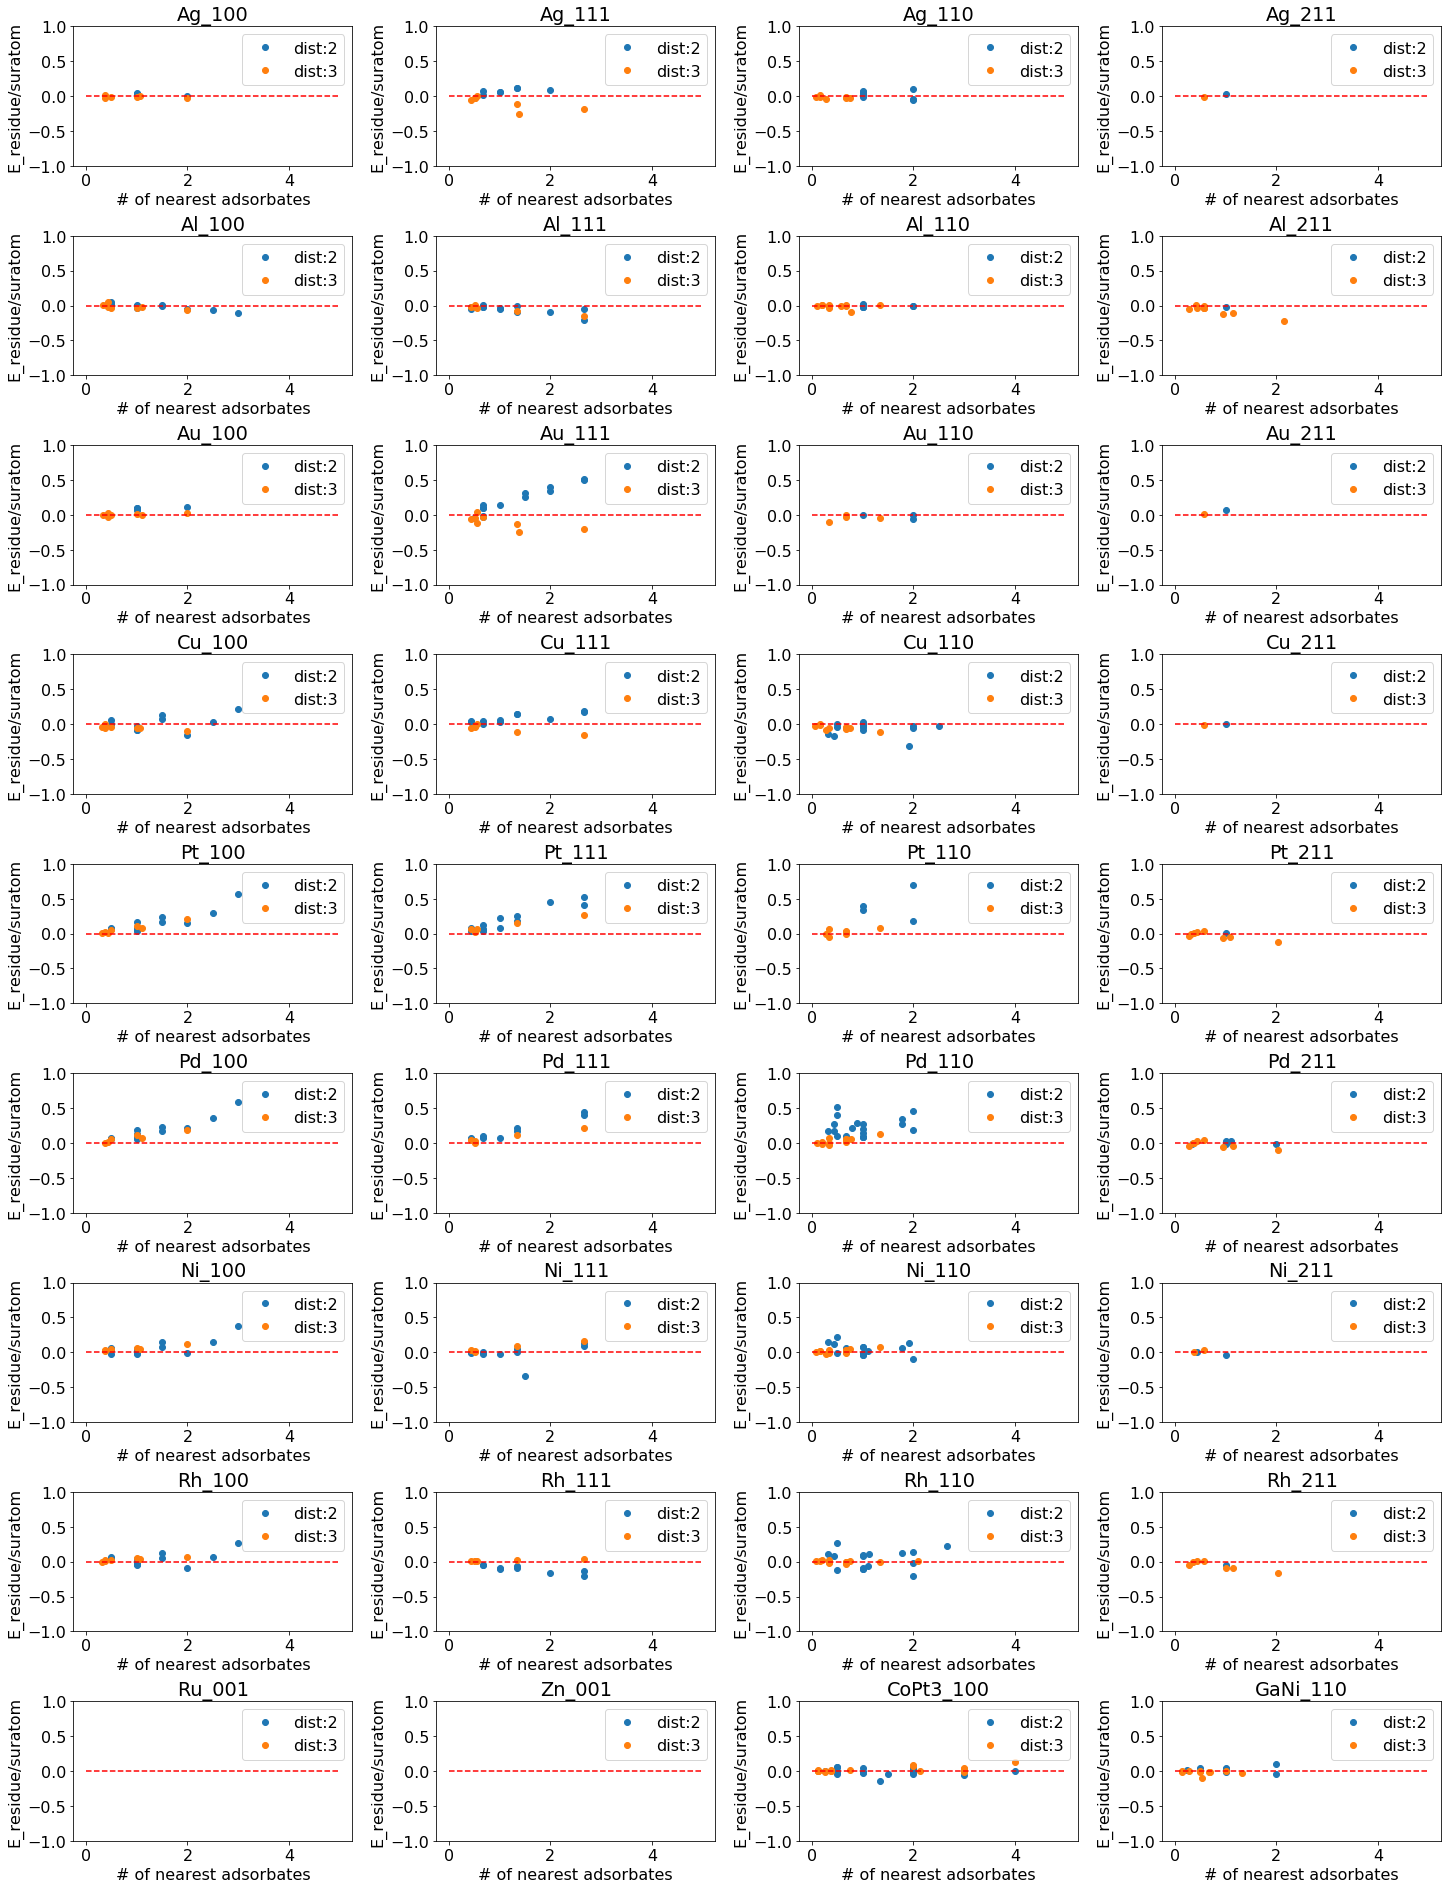

In [17]:
fig = plt.figure(figsize=(20,30))
plt.rcParams["font.size"] = 16


xmin = 0
xmax = 5
for i in range(len(dfpred)):
    ax = fig.add_subplot(9, 4, i+1)
    ax.plot(dfpred[i][dfpred[i]['minimum_distance']==2]['ads_dist2'], dfpred[i][dfpred[i]['minimum_distance']==2]['E_residue/suratom'], 'o')
    ax.plot(dfpred[i][dfpred[i]['minimum_distance']==3]['ads_dist3'], dfpred[i][dfpred[i]['minimum_distance']==3]['E_residue/suratom'], 'o')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('E_residue/suratom')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.legend(['dist:2','dist:3'])
# plt.savefig('')
  #  plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

Ag 100 0.0002761508429761471
Ag 111 0.001978378410987031
Ag 110 0.0015090761389492128
Ag 211 0.0
Al 100 0.0007246945326333035
Al 111 0.0013377793316638963
Al 110 0.00042055398221974396
Al 211 0.000645551954345784
Au 100 0.00033556247727992573
Au 111 0.0037410975339598924
Au 110 0.0016917757731871033
Au 211 6.018531076210112e-36
Cu 100 0.003685418481774451
Cu 111 0.000858445504465772
Cu 110 0.004934735877665881
Cu 211 0.0
Pt 100 0.0064025419404266535
Pt 111 0.0017249332089235264
Pt 110 0.010631599069061205
Pt 211 0.000855032512893161
Pd 100 0.004461460911570239
Pd 111 0.0009934431419526212
Pd 110 0.01138579964134404
Pd 211 0.0006990630161333502
Ni 100 0.005985138313640842
Ni 111 0.010967941401468591
Ni 110 0.004103176112892974
Ni 211 0.00013047250076900468
Rh 100 0.0053159318255023204
Rh 111 0.0005577405637661706
Rh 110 0.009207832416909303
Rh 211 0.0009803692993868704
CoPt3 100 0.0009818819805743144
GaNi 110 0.0011620387994247176


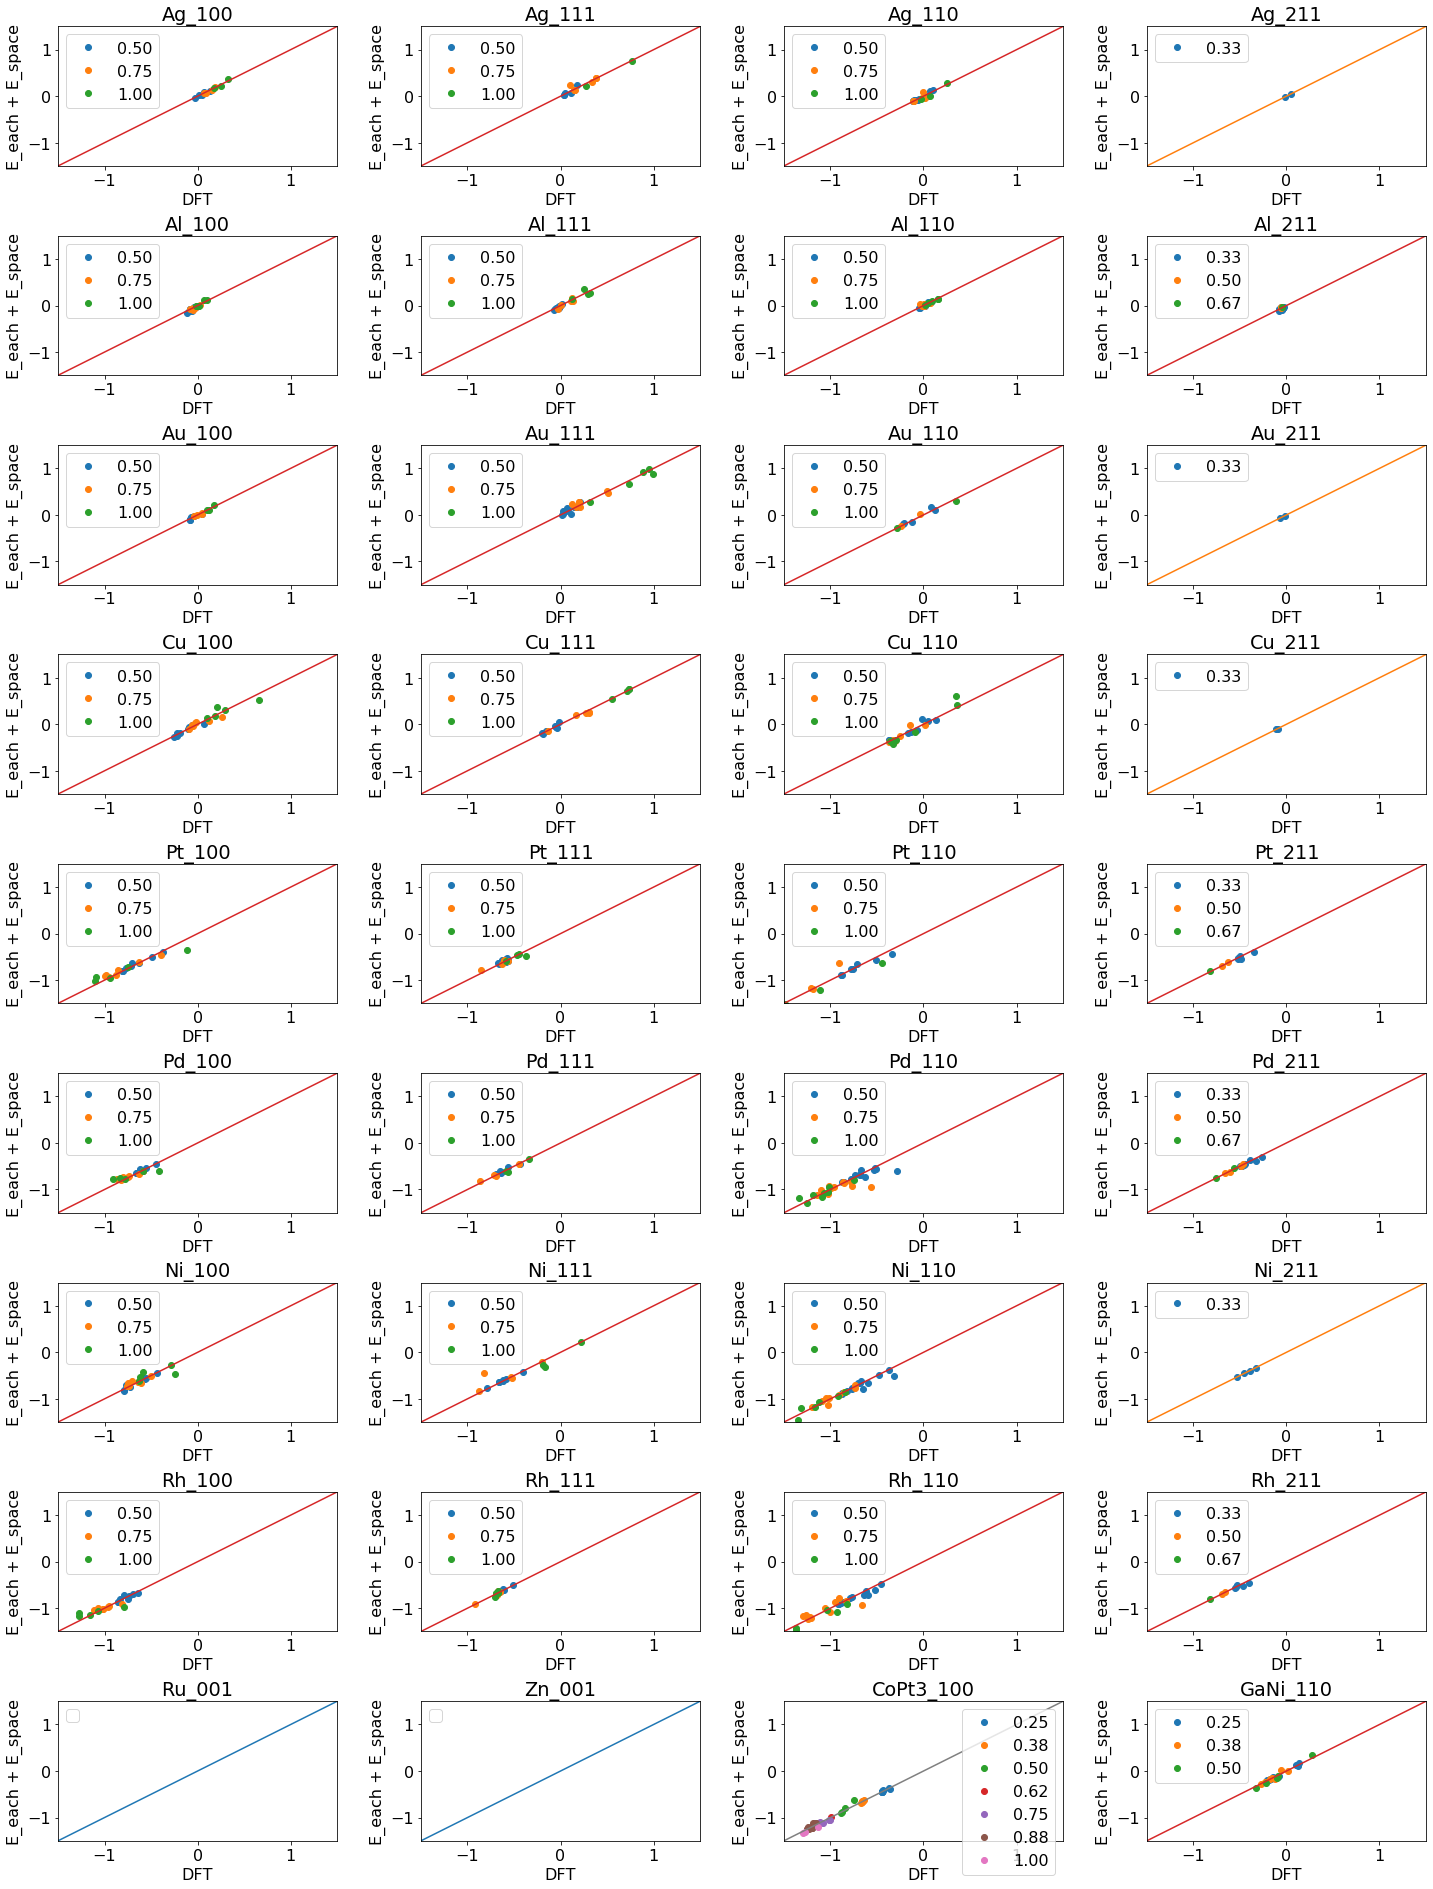

In [18]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(20,30))
plt.rcParams["font.size"] = 16

for i in range(len(dfpred)):
    ax = fig.add_subplot(9, 4, i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        try:
            weight2, weight3 = inst[i].fit_weight_from_specific_element_and_face()
            data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]

            E_residue_pred = data['ads_dist2'] * weight2 + data['ads_dist3'] * weight3
            E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred

            aveadsE_suratom = data['aveadsE/suratom']
            if not aveadsE_suratom.any():
                continue
            if xmin > np.min(aveadsE_suratom):
                xmin = np.min(aveadsE_suratom)
            if xmax < np.max(aveadsE_suratom):
                xmax = np.max(aveadsE_suratom)
            ax.plot(aveadsE_suratom, E_ads_pred, 'o')
        except:
            print('a')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    
    if not covset[i]:
        continue
    data = dfpred[i]
    E_residue_pred = data['ads_dist2'] * weight2 + data['ads_dist3'] * weight3
    E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred
    aveadsE_suratom = data['aveadsE/suratom']    
    print(dictlis[i]['element'], dictlis[i]['face'], mean_squared_error(aveadsE_suratom, E_ads_pred))

plt.savefig('E_pred_wmf_method3.png', bbox_inches='tight')
# plt.show()

In [9]:
# dfall[14]

In [10]:
# query('Cu_110_u2_RPBE_no003_CO_n1_d8_all.traj','local')

Ag 100 0.0018411336836974149
Ag 111 0.00454974379277868
Ag 110 0.0026440968944624246
Ag 211 0.00026669171641167776
Al 100 0.001269099383903586
Al 111 0.0016998087249261511
Al 110 0.0008513841845688545
Al 211 0.0021801296748458214
Au 100 0.004143780835083587
Au 111 0.009817264432539947
Au 110 0.026308223557920906
Au 211 0.003259375650186758
Cu 100 0.0035256250854345155
Cu 111 0.006959252519094309
Cu 110 0.009379656103306416
Cu 211 0.00042044210802028503
Pt 100 0.006831785879837895
Pt 111 0.002530093180581566
Pt 110 0.017332275956600238
Pt 211 0.011962187168685488
Pd 100 0.003916546209753312
Pd 111 0.001177794919079447
Pd 110 0.014098228990796111
Pd 211 0.018454267436215234
Ni 100 0.007149271180936055
Ni 111 0.012536720232449313
Ni 110 0.004075794913779409
Ni 211 0.0010265888000755483
Rh 100 0.006348330565208201
Rh 111 0.007948198569178822
Rh 110 0.009711242338258685
Rh 211 0.005865849158484794
CoPt3 100 0.0009818819805743144
GaNi 110 0.0011543451938072365


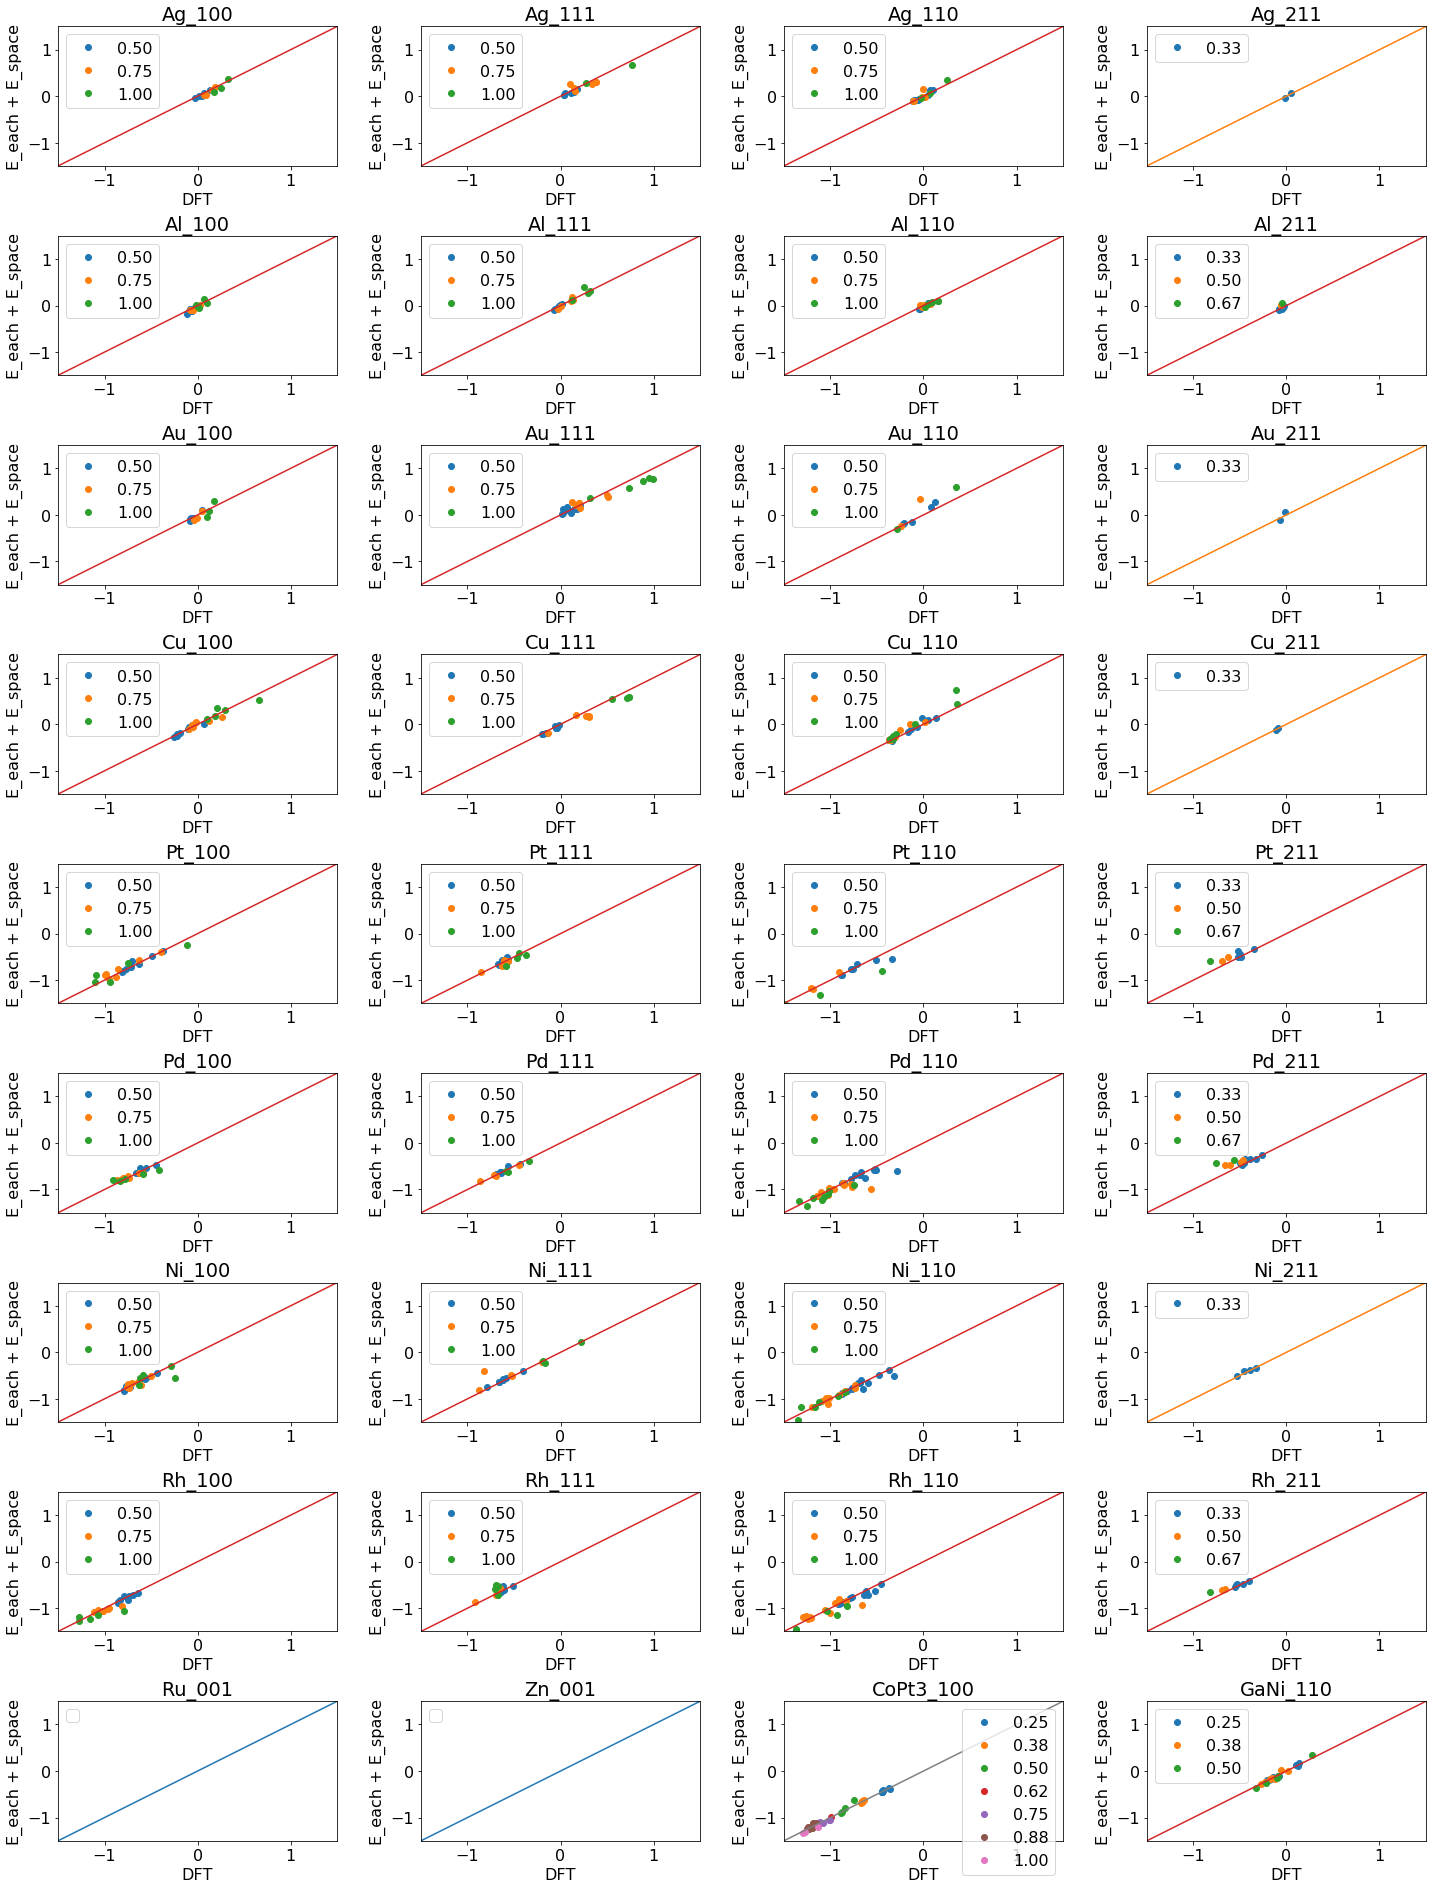

In [11]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(20,30))
plt.rcParams["font.size"] = 16

for i in range(len(dfpred)):
    ax = fig.add_subplot(9, 4, i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        weight2, weight3 = inst[i].fit_weight_from_specific_element()
        data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        
        E_residue_pred = data['ads_dist2'] * weight2 + data['ads_dist3'] * weight3
        E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred

        aveadsE_suratom = data['aveadsE/suratom']
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_ads_pred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    
    if not covset[i]:
        continue
    data = dfpred[i]
    E_residue_pred = data['ads_dist2'] * weight2 + data['ads_dist3'] * weight3
    E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred
    aveadsE_suratom = data['aveadsE/suratom']    
    print(dictlis[i]['element'], dictlis[i]['face'], mean_squared_error(aveadsE_suratom, E_ads_pred))

plt.savefig('E_pred_wm_method2.png', bbox_inches='tight')
# plt.show()

In [28]:
# dfall[22]

In [29]:
# query('Pd_110_u2_RPBE_no002_CO_n1_d9.traj','local')